# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=hcf.PS_choffs) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [3]:
# set current================================================
current_percent = 90.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [4]:
# set MW frequency =====================================================
f_NVguess = 398.5607725381851
f_NVguess = 398.5547716319561
# f_NVguess = 392.83677300810814
f_NVguess = 392.8397714495659
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.36832381039858 GHz
Actual Output CW Freqeuncy :16.36832381039858 GHz


In [6]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)


1

In [ ]:
task_uca.stop()
task_uca.close()

In [95]:
# set MW reflection monitoring =====================================================
from math import lcm
srate_zbd = hcf.NI_sampling_max # Hz
dt_zbd = int(1/srate_zbd*1E9) # ns
task_zbd = nidaqmx.Task("ZBD") # user controlled attenuation
task_zbd.ai_channels.add_ai_voltage_chan(hcf.NI_ch_ZBD, min_val=-10.0, max_val=10)
task_zbd.timing.cfg_samp_clk_timing(srate_zbd, 
                                    source=hcf.NI_ch_Clock, 
                                    active_edge=Edge.RISING,
                                    sample_mode=AcquisitionType.CONTINUOUS)
num_read = int(0.1*srate_zbd) # say acquire for 0.5s
sw_period = int(50E3) # [ns]
leastrepeat = lcm(dt_zbd, sw_period)
pg.resetSeq()
pg.setDigital("mwA", [(sw_period/2.0, LOW), (sw_period/2.0, LOW)]*int(leastrepeat/sw_period))
pg.setDigital("mwB", [(sw_period/2.0, HIGH), (sw_period/2.0, LOW)]*int(leastrepeat/sw_period))
pg.setDigital("dclk", [(dt_zbd/2.0, HIGH), (dt_zbd/2.0, LOW)]*int(leastrepeat/dt_zbd))
REPEAT_INFINITELY = -1
pg.stream(n_runs=REPEAT_INFINITELY)
# task_zbd_readtrig = task_zbd.triggers.start_trigger
# task_zbd_readtrig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)
# task_zbd_reader = AnalogSingleChannelReader(readtask.in_stream)
# task_zbd_reader.read_all_avail_samp  = True

# Start the task
# task_zbd.start()
print("Reading values...")
# zbddata = []
# for _ in range(1000):  # Read 10 values
#     value = task_zbd.read()  # Read a single sample
#     zbddata.append(value)
#     print(f"Analog Value: {value}")
zbd_samples = task_zbd.read(number_of_samples_per_channel=num_read, timeout=10.0)


pg.forceFinal()
task_zbd.stop()
task_zbd.close()

Reading values...


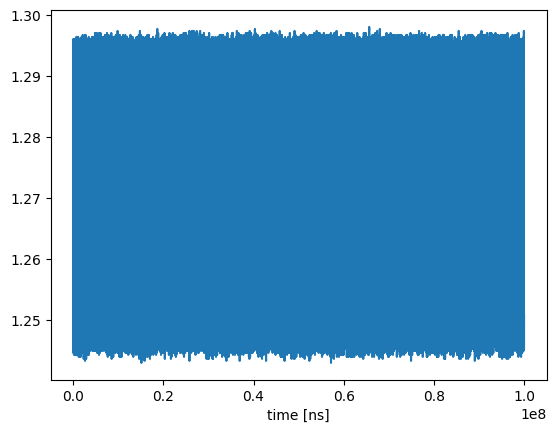

In [96]:
dt = 1E9/srate_zbd # ns
zbd_time = np.arange(0, num_read*dt, dt)
plt.plot(zbd_time, zbd_samples)
plt.xlabel("time [ns]")
plt.show()

In [97]:
from scipy.optimize import curve_fit

# Generate a square wave
def square_wave(t, frequency, amplitude, phase, offset):
    return amplitude * 0.5 * (1 + np.sign(np.sin(2 * np.pi * frequency * t + phase)))+offset

# Define a model with multiple square waves (sum of square waves)
def square_wave_model(t, *params):
    num_waves = len(params) // 3  # Each square wave has 3 parameters: frequency, amplitude, phase
    signal = np.zeros_like(t)
    
    # Loop over each square wave component
    for i in range(num_waves):
        freq = params[i*3]        # Frequency of the square wave
        amp = params[i*3+1]       # Amplitude of the square wave
        phase = params[i*3+2]     # Phase of the square wave
        offset = params[i*3+3]    # offset of the square wave
        signal += square_wave(t, freq, amp, phase, offset)
    
    return signal

# get the signal
t = zbd_time
signal = zbd_samples

# Initial guesses for the square wave parameters (frequency, amplitude, phase)
# You should provide reasonable initial guesses based on your signal
initial_guess = [1/sw_period, np.max(signal)-np.min(signal), 0.0, np.mean(signal)]

# Fit the signal with the square wave model
params_opt, params_cov = curve_fit(square_wave_model, t, signal, p0=initial_guess)

# Reconstruct the signal using the fitted parameters
fitted_signal = square_wave_model(t, *params_opt)


C:\Users\ctcheung\AppData\Local\Temp\ipykernel_40472\391811070.py:31: OptimizeWarning:

Covariance of the parameters could not be estimated



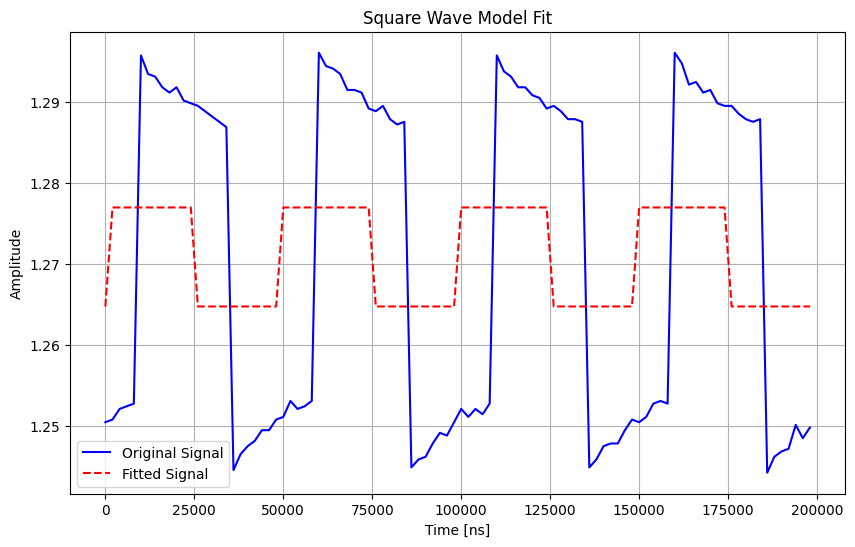

Fitted Parameters:
Square Wave 1:
  Frequency: 20000.00 Hz
  Amplitude: 0.01
  Phase: -0.00 radians
  Offsets: 1.26


In [98]:
# Plot the original and fitted signals
plt.figure(figsize=(10, 6))
plt.plot(t[0:100], signal[0:100], label="Original Signal", color='blue')
plt.plot(t[0:100], fitted_signal[0:100], label="Fitted Signal", linestyle="--", color='red')
plt.title('Square Wave Model Fit')
plt.xlabel('Time [ns]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized parameters
num_waves = len(params_opt) // 4
print("Fitted Parameters:")
for i in range(num_waves):
    print(f"Square Wave {i+1}:")
    print(f"  Frequency: {params_opt[i*3]*1E9:.2f} Hz")
    print(f"  Amplitude: {params_opt[i*3+1]:.2f}")
    print(f"  Phase: {params_opt[i*3+2]:.2f} radians")
    print(f"  Offsets: {params_opt[i*3+3]:.2f}")

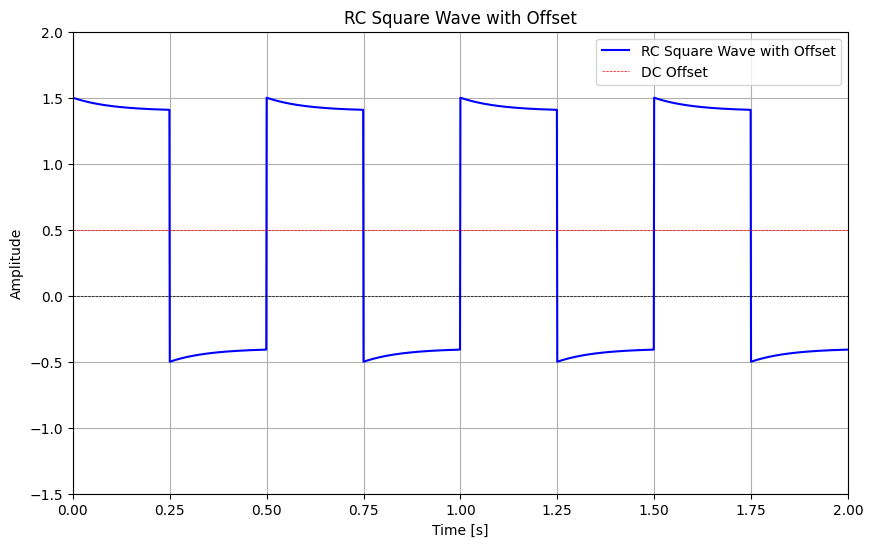

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# RC square wave model with offset: combines exponential rise and fall with DC offset
def rc_square_wave_with_offset(t, frequency, amplitude, phase, amp_discharge, rc, offset):
    period = 1 / frequency
    half_period = period / 2
    dt = (t[-1]-t[0])/len(t)
    t_shifted = (t + phase / (2 * np.pi * frequency)) % period # Shift by phase
    rc_wave = np.zeros_like(t)
    # print(t_shifted)
    flipflop = t_shifted < half_period
    rcwave_fronthalf = (amplitude-amp_discharge * (1 - np.exp(-t_shifted / rc)))
    rcwave_endhalf = (-amplitude+amp_discharge * (1 - np.exp(-(t_shifted - half_period) / rc)))
    rc_wave = flipflop*rcwave_fronthalf + (~flipflop)*rcwave_endhalf
    # Add the offset to the square wave and the RC modification
    return  rc_wave + offset
    # return rc_wave + offset

# Generate example data for plotting
def generate_example_signal():
    # Time array
    sample_rate = 1000  # Sample rate (Hz)
    duration = 2.0  # Duration of the signal (seconds)
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

    # Parameters for the RC square wave
    frequency = 2.0  # Frequency of the square wave (Hz)
    amplitude = 1.0  # Amplitude of the square wave
    phase = 0.0  # Phase shift (radians)
    amp_discharge = 0.1  # Amplitude of discharge
    rc = 0.1  # RC time constant (seconds)
    offset = 0.5  # DC offset

    # Generate the RC square wave signal
    signal = rc_square_wave_with_offset(t, frequency, amplitude, phase, amp_discharge, rc, offset)
    
    return t, signal

# Main function to execute the example
def main():
    # Generate the example signal
    t, signal = generate_example_signal()

    # Plot the RC square wave with offset
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal, label='RC Square Wave with Offset', color='blue')
    plt.title('RC Square Wave with Offset')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Horizontal line at y=0
    plt.axhline(0.5, color='red', linewidth=0.5, linestyle='--', label='DC Offset')  # Highlighting the offset
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 2)
    plt.ylim(-1.5, 2.0)
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()


In [149]:
False*False

0

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# RC square wave model with offset: combines exponential rise and fall with DC offset
def rc_square_wave_with_offset(t, frequency, amplitude, phase, amp_discharge, rc, offset):
    period = 1 / frequency
    half_period = period / 2
    dt = (t[-1]-t[0])/len(t)
    t_shifted = (t + phase / (2 * np.pi * frequency)) % period # Shift by phase
    rc_wave = np.zeros_like(t)

    flipflop = t_shifted > half_period
    rcwave_fronthalf = (amplitude-amp_discharge * (1 - np.exp(-t_shifted / rc)))
    rcwave_endhalf = (-amplitude+amp_discharge * (1 - np.exp(-(t_shifted - half_period) / rc)))
    rc_wave = flipflop*rcwave_fronthalf + (~flipflop)*rcwave_endhalf
    # Add the offset to the square wave and the RC modification
    return  rc_wave + offset


# get the signal
t = zbd_time
signal = zbd_samples

# Initial guesses for the square wave parameters (frequency, amplitude, phase)
# You should provide reasonable initial guesses based on your signal
amp_guess = (np.max(signal)-np.min(signal))/2.0
initial_guess = [1/sw_period, amp_guess, 0.0, amp_guess/2.0, sw_period, np.mean(signal)]

# Fit the RC square wave model with offset to the signal
params_opt, params_cov = curve_fit(rc_square_wave_with_offset, t, signal, p0=initial_guess)

# Reconstruct the signal using the fitted parameters
fitted_signal = rc_square_wave_with_offset(t, *params_opt)



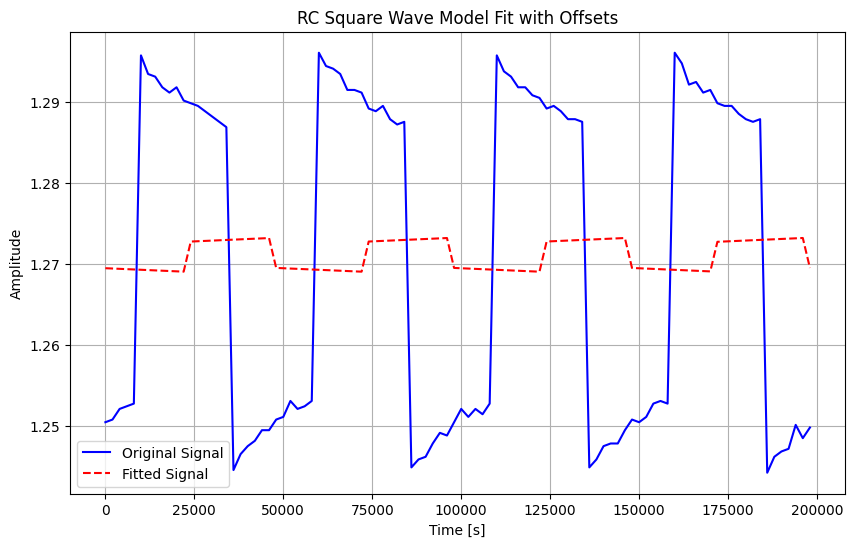

Fitted Parameters:
RC Square Wave 1:
  Frequency: 0.00 Hz
  Amplitude: 0.00
  Phase: 31.74 radians
  RC Time Constant: 0.0616 seconds
  Offset: -3181592.0154


In [187]:
# Plot the original and fitted signals
plt.figure(figsize=(10, 6))
plt.plot(t[0:100], signal[0:100], label="Original Signal", color='blue')
plt.plot(t[0:100], fitted_signal[0:100], label="Fitted Signal", linestyle="--", color='red')
plt.title('RC Square Wave Model Fit with Offsets')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized parameters
num_waves = len(params_opt) // 5
print("Fitted Parameters:")
for i in range(num_waves):
    print(f"RC Square Wave {i+1}:")
    print(f"  Frequency: {params_opt[i*5]:.2f} Hz")
    print(f"  Amplitude: {params_opt[i*5+1]:.2f}")
    print(f"  Phase: {params_opt[i*5+2]:.2f} radians")
    print(f"  RC Time Constant: {params_opt[i*5+3]:.4f} seconds")
    print(f"  Offset: {params_opt[i*5+4]:.4f}")


In [5]:
laser_init = 6400
wait_init = 800
mw_dur_start = 10.0
mw_dur_stop = 2400
mw_dur_step = 16.0
mw_dur = np.arange(mw_dur_start, mw_dur_stop+mw_dur_step, mw_dur_step)
# mw_dur = np.geomspace(mw_dur_start, mw_dur_stop, 320, endpoint=True)
# rounding is IMPORTANT!!
# mw_dur = np.round(NI_ratebase*mw_dur)*NI_timebase # round to DAQ timebase
mw_dur = np.round(mw_dur) # round to PS timebase
mw_dur_stop = mw_dur[-1]
mw_dur_start = mw_dur[0]
wait_read = 300
laser_read = 800

# here is to fix the timing
totaltime_max = laser_init+wait_init+mw_dur_stop+wait_read+laser_read
tbmultiple = int(hcf.NI_ratebase*totaltime_max+1)
sampling_rate = hcf.NI_ratebase/tbmultiple
sampletime = round(1.0/sampling_rate)
samplerate = 1.0/sampletime #GHz
padding_fix = sampletime-totaltime_max
padding = padding_fix+mw_dur_stop-mw_dur # depends on MW duration
num_pt = len(mw_dur)

assert np.all(padding+mw_dur+laser_init+wait_init+wait_read+laser_read == sampletime)
assert padding_fix >= 0


In [7]:
# readoffset = NI_timebase*30
delaydiff = hcf.NI_timebase*15.0
readoffset = hcf.NI_timebase*25.0
# delaydiff = NI_timebase*0.0
# readoffset = laser_read - 20
daqpadding = sampletime - (laser_read - readoffset - delaydiff)
daqpadding = int(hcf.NI_ratebase*daqpadding)/hcf.NI_ratebase
# daqdelay = NI_timebase*20.0
daqdelay = 0.0
daqtriggerdelay = hcf.NI_timebase*0.0
# daqpadding = 1.0/clock_rate*1.0
# daqpadding = int(clock_rate*(1.0/sampling_rate-(laser_read-250.0)))/clock_rate
# daqpadding = 0.0


seq_daqtrig = [(daqdelay, LOW)] + [(daqtriggerdelay, LOW)] + [(daqpadding-hcf.NI_ratebase*10, LOW)] + [(sampletime, HIGH), (sampletime*(num_pt*2 - 1) - daqtriggerdelay-daqpadding+hcf.NI_ratebase*10, LOW)]
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple+int(daqpadding*clock_rate))
# seq_clock = [(daqpadding, LOW)] + [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple)
seq_clock = [(daqdelay, LOW)] + [(daqpadding, LOW),(sampletime-daqpadding, HIGH)]*num_pt*2
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]

seq_laser = []
seq_mwA = []
seq_mwB = []
skip = 0
seq_laser_sub_alloff = [(padding[-1], LOW), (laser_init, LOW), (wait_init, LOW), (mw_dur[-1], LOW), (wait_read, LOW), (laser_read, LOW)]
# for mwd, pd in zip(mw_dur, padding):
for ii in range(len(mw_dur)-skip):
    mwd = mw_dur[ii]
    pd = padding[ii]
    seq_laser_sub = [(pd, LOW), (laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH)]
    seq_mwA_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_noMW_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW)]
    # seq_laser_sub = [(laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH), (pd, LOW)]
    # seq_mwA_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    # seq_mwA_noMW_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    seq_laser += seq_laser_sub + seq_laser_sub
    # seq_laser += seq_laser_sub + seq_laser_sub_alloff
    seq_mwA += seq_mwA_sub + seq_mwA_noMW_sub
    seq_mwB += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
    # seq_mwA += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
seq_laser += (seq_laser_sub_alloff + seq_laser_sub_alloff)*skip
seq_mwA += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_mwB += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_laser +=  [(daqdelay, LOW)]
seq_mwA +=  [(daqdelay, LOW)]
seq_mwB +=  [(daqdelay, LOW)]
# seq_laser = [(daqtrigdelay,LOW)] + seq_laser
# seq_laser = [(0.5/clock_rate, HIGH),(0.5/clock_rate, HIGH)]*(num_pt*2*clockmultiple+int(daqtrigdelay*clock_rate))
# seq_mwA = [(daqtrigdelay,LOW)] + seq_mwA
# seq_laser += [(daqpadding, LOW)]
# seq_mwA += [(daqpadding, LOW)]

rrr = 8
pg.setDigital("laser", seq_laser*rrr)
pg.setDigital("mwA", seq_mwA*rrr)
pg.setDigital("mwB", seq_mwB*rrr)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("dtrig", seq_daqtrig*rrr)
pg.setDigital("dclk", seq_clock*rrr)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
assert round(np.sum(np.array(seq_laser)[:, 0])) == round(np.sum(np.array(seq_mwA)[:, 0])) == round(np.sum(np.array(seq_daqtrig)[:, 0])) == round(np.sum(np.array(seq_clock)[:, 0]))
assert sampletime > daqpadding + 10

In [ ]:
aa = np.sum(np.array(seq_laser)[:, 0])
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_mwA)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_daqtrig)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_clock)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")

In [9]:
# signal reading parameters
min_volt = -0.001 # [V]
max_volt = 0.010
samplerate_read = samplerate*1E9 # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readsample = num_pt*2
timeout_read = max(2*num_readsample/samplerate_read, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hcf.NI_ch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hcf.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS, 
    # sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [192]:
readtask.close()

# Start measurement


In [10]:
laser.laser_on() # turn on laser

In [194]:
laser.laser_off() # turn on laser

In [ ]:
pg.stream(n_runs=INF)
pg.startNow()
# signal = np.zeros(num_pt)
# background = np.zeros(num_pt)
# repeat measurement

signal_av = np.zeros(num_pt, dtype=np.float64, order='C')
background_av = np.zeros(num_pt, dtype=np.float64, order='C')
readtask.start() # ready to read data
read_duration = 60  # read data for 5 seconds
start_time = time.time()
num_repeat = 0
while time.time() - start_time < read_duration:
# for kkk in range(num_repeat):
    # readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            num_readsample,
            timeout_read
        )
    # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    signal_av += np.copy(buffer_readpoint[0::2])
    background_av += np.copy(buffer_readpoint[1::2])
    # readtask.stop()
    num_repeat += 1
readtask.stop()
# laser.laser_off()
# readtask.close()
signal_av = signal_av/num_repeat
background_av = background_av/num_repeat
contrast = (signal_av-background_av)/background_av
print(f"measurement repeat : {num_repeat} times")

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 200
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

In [ ]:
# to save file
# Data to save
import pickle
data = {
    'mw_dur': mw_dur,
    'freq_actual': freq_actual,
    'signal_av': signal_av,
    'background_av': background_av, 
    'contrast': contrast, 
}

# File path
filename = f"m1rabi_ccw_wi_init6400nsthplasticmetalholder_range{mw_dur_stop}us_z70um.pkl"
dir = "output\\20240506_eveningmeasurementdebug"
file_path = f'{dir}\\{filename}'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    # Write data to the file using pickle.dump()
    pickle.dump(data, f)

print(f'Data saved to {file_path}')

In [159]:
# File path
file_path = file_path
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_392.8397714495659.pkl"
# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Read data from the file using pickle.load()
    data = pickle.load(f)

# Access your data variables
mw_dur = data['mw_dur']
freq_actual = data['freq_actual']
signal_av = data['signal_av']
background_av = data['background_av']
contrast = data['contrast']

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 500
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

In [ ]:
# Access the contrast data and time domain
contrast = data['contrast']
mw_dur = data['mw_dur']

# Remove the DC component (constant offset) by subtracting the mean
contrast_centered = contrast - np.mean(contrast)
# contrast_centered = contrast

# Perform the FFT after removing DC
# Convert fid_dur from nanoseconds to seconds for correct frequency calculation
sampling_interval = (mw_dur[1] - mw_dur[0]) * 1e-3  # Convert ns to us

# Compute FFT and corresponding frequencies
contrast_fft = np.fft.fft(contrast_centered)
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)

# Filter out the negative frequencies
positive_frequencies = frequencies[frequencies >= 0]
positive_fft = contrast_fft[frequencies >= 0]

# Plot only the positive frequencies
plt.figure()
plt.plot(positive_frequencies, np.abs(positive_fft), label='Contrast FFT (Positive Frequencies)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('FID Spectrum (DC Removed)')
plt.legend()
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}_fft.jpg")

In [ ]:
from scipy.optimize import curve_fit
# Define Lorentzian function
def lorentzian(x, amplitude, center, width):
    return amplitude / (1.0 + ((x - center) / width) ** 2)

# Perform the FFT (with DC removal)
sampling_interval = (mw_dur[1] - mw_dur[0]) * 1e-9  # Convert ns to s
contrast_fft = np.fft.fft(contrast_centered)

# Get the positive frequencies and their FFT results
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)
positive_indices = frequencies >= 0
positive_frequencies = frequencies[positive_indices]
positive_fft = contrast_fft[positive_indices]

# Get the magnitude of the positive FFT
fft_magnitude = np.abs(positive_fft)

# Identify peak regions for fitting
threshold = 0.6 * np.max(fft_magnitude[80:])  # Relative threshold
peak_indices = list(np.array(np.where(fft_magnitude[80:] > threshold)[0]) + 80)

# Group peak indices to identify unique peaks and double their range
peak_groups = []
current_group = []

# Identify groups of peaks
for i in peak_indices:
    if not current_group:
        current_group.append(i)
    elif i - current_group[-1] <= 5:
        current_group.append(i)
    else:
        peak_groups.append(current_group)
        current_group = [i]

# Add any remaining group
if current_group:
    peak_groups.append(current_group)

# Extend each group by doubling its range
extended_peak_groups = []
for group in peak_groups:
    # Extend the start and end of each group by doubling its length
    start = max(0, group[0] - 20*len(group))  # Ensure it doesn't go below zero
    end = min(len(positive_frequencies) - 1, group[-1] + 20*len(group))  # Ensure it doesn't go out of bounds
    extended_peak_groups.append(list(range(start, end)))

# Fit Lorentzian to each extended peak group
fitted_peaks = []
plt.figure()
plt.plot(positive_frequencies, fft_magnitude, label="Original FFT")

# Increase maxfev for more complex fittings
maxfev = 2000  # Adjust as needed

# Iterate over each extended peak group for fitting
for group in extended_peak_groups:
    # Get the mid-point of the group as the initial guess for the center
    initial_center = positive_frequencies[group[len(group) // 2]]
    initial_amplitude = fft_magnitude[group[len(group) // 2]]
    initial_width = 1e6  # An initial guess for width

    try:
        # Perform curve fitting with constraints and bounds
        popt, _ = curve_fit(
            lorentzian,
            positive_frequencies[group],
            fft_magnitude[group],
            p0=[initial_amplitude, initial_center, initial_width],
            maxfev=maxfev,
            bounds=([0, initial_center - 5e6, 1e5], [np.inf, initial_center + 5e6, 1e7]),  # Constrained bounds
        )

        # Extract fitted parameters
        amplitude, center, width = popt
        fitted_peaks.append(center)

        # Plot the fitted Lorentzian curve
        plt.plot(
            positive_frequencies,
            lorentzian(positive_frequencies, amplitude, center, width),
            '--',
            label=f"Fitted Lorentzian (Center: {center:.2e} Hz)",
        )
    except RuntimeError:
        print(f"Could not fit Lorentzian for peak group centered at {initial_center:.2e} Hz")

# Zoom in to the fitted peak regions
peak_centers = np.array(fitted_peaks)
zoom_margin_lower = 0.5e6  # Adjust as needed for lower margin
zoom_margin_higher = 1.5e6  # Adjust as needed for upper margin

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with Lorentzian Fits (Zoomed In)")
plt.legend()
plt.xlim(max(0, peak_centers.min() - zoom_margin_lower), peak_centers.max() + zoom_margin_higher)  # Set x-axis limits to zoom
plt.ylim(0, 1)
# Output the fitted peak frequencies
print("Fitted peak frequencies:")
for peak in fitted_peaks:
    print(f"{peak:.2e} Hz")

In [ ]:
1/725/2

In [13]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
# mwsyn.reboot()

In [ ]:
mwsyn.reboot()

In [15]:
# close the communication
laser.close()
mwsyn.close()


In [16]:
pg.reset()